# Práctica 1: Aprendizaje automático

__Fecha de entrega: 9 de marzo de 2022__

El objetivo de esta práctica es aplicar los distintos algoritmos de aprendizaje automático disponibles en la scikit-learn [sklearn](https://scikit-learn.org/stable/) sobre varios conjuntos de datos y aprender a interpretar los resultados obtenidos. La práctica consta de 3 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

# Apartado 1: Clustering

__Número de grupo: 11__

__Nombres de los estudiantes: Aitor Esteban y Edurne Ruiz__

## 1) Carga del conjunto de datos

Crea un dataframe a partir del fichero `prestamos.csv` que se proporciona junto con la práctica. 

El conjunto de datos contiene por cada fila los datos de un préstamo que fue concedido por una empresa de crédito p2p. Las variables que caracterizan el préstamo son las siguientes:
  - `loan_amnt` es la cantidad de dinero solicitada en dólares
  - `purpose` es el propósito para el que se solicitó el préstamo
  - `revenue` son los ingresos anuales en dólares de la persona que solicitó el préstamos
  - `dti_n` es el porcentaje de endeudamiento sobre los ingresos anuales de la persona que solicitó el préstamo
  - `fico_n` se trata de un indicador de solvencia de la persona que solicitó el préstamo. A mayor puntuación, mayor solvencia, y además se cuenta con estos rangos orientativoss:
    - 300-550: Pobre
    - 550-620: Subprime (alto riesgo)
    - 620-680: Crédito aceptable
    - 680-740: Buen crédito
    - 740-850: Excelente crédito

  -`home_ownership_n` es una variable categórica que indica la situación de vivienda en la que vive la persona solicitante
    - `OWN` es en propiedad
    - `MORTAGAGE` indica que está hipotecada
    - `RENT` indica que vive en alquiler
    - `OTHER` es una categoría que agrega otras posibilidades

- `emp_length` es una variable ordinal, no es estrictamente numérica, ya que el valor 0 denota que no consta información, los valores entre 1 y 10 indican una permanencia inferior a X años, y el valor 11 indica una permanencia superior a 10 años.
- `Default` es la variable que usaremos como **variable objetivo** del conjunto de datos e indica si la persona incumplió (incurrió en *default*) o no el préstamo.


Como pandas no tiene forma de saber que las variables `home_ownership_n`, `emp_length` y `Default` son en realidad categóricas, debes indicárselo tú.

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('prestamos.csv')
df

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default
0,32000,car,135000.0,18.93,687.0,MORTGAGE,1,0
1,32000,car,90000.0,9.29,822.0,MORTGAGE,10,1
2,30000,car,95000.0,1.34,722.0,RENT,11,0
3,25750,car,230000.0,6.42,747.0,MORTGAGE,11,0
4,25200,car,72000.0,30.95,692.0,OWN,11,0
...,...,...,...,...,...,...,...,...
13789,1275,vacation,42000.0,31.89,792.0,RENT,0,0
13790,1200,vacation,36000.0,12.27,747.0,MORTGAGE,8,0
13791,1000,vacation,76000.0,25.26,702.0,MORTGAGE,11,0
13792,1000,vacation,32000.0,17.70,747.0,MORTGAGE,0,0


In [3]:
#Indicamos las variables categóricas
df['Default'] = df['Default'].astype('category')
df['home_ownership_n'] = df['home_ownership_n'].astype('category')
df['emp_length_n'] = df['emp_length_n'].astype('category')

In [4]:
df.dtypes

loan_amnt              int64
purpose               object
revenue              float64
dti_n                float64
fico_n               float64
home_ownership_n    category
emp_length_n        category
Default             category
dtype: object

## 2) Análisis de los datos

### 2.1) Numéricos

Analiza razonadamente las distribuciones de cada una de las variables numéricas (medias, desviaciones típicas, rangos, ...) y las principales relaciones entre pares de variables (diagrama de dispersión, coeficientes de correlación, ...).

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,13794.0,14507.833116,9037.938271,1000.0,7300.0,12000.000,20000.0000,40000.00
revenue,13794.0,79737.299507,56463.579892,7000.0,48000.0,68000.000,97000.0000,1650000.00
dti_n,13794.0,18.825106,9.795986,0.0,12.2,18.085,24.7575,190.87
fico_n,13794.0,699.106822,32.825754,662.0,672.0,692.000,717.0000,847.50


-Loan_amnt: observamos que la desviación típica es elevada con respecto a la media por lo que se deduce que los préstamos solicitados son muy diferentes. Los percentiles nos indican que está todo distrubuido de forma bastante uniforme.

-Revenue: observamos que la media de los ingresos anuales de las personas que solicitaron préstamos es elevada pero la desviación típica es también notoria. Esto se puede apreciar en el rango de valores ya que vemos que el mínimo es 7000, una cantidad muy baja y el maximo 1650000 que es una cantidad muy elevada. Esto y los percentiles nos indican que hay mucha variedad en los ingresos de los solicitantes de préstamos.

-Dti_n: en cuanto al porcentaje de endeudamiento observamos que la media es inferior al 20% y que la desviación típica no es muy elevada. Lo notorio es que el máximo es 190.87% por lo que hay solicitantes que tienen un porcentaje de endeudamiento respecto de sus ingresos superior al 100%. Sin embargo el percentil del 75% nos indica que la mayoría de los solicitantes tienen un dti_n menor al 24.7575% y que hay pocos con valores elevados.

-Fico_n: la media nos indica que en general los solicitantes tienen buen crédito y la desviación típica es baja por lo que los valores no varían mucho. Observamos que la mayoría de los solicitantes se encuetran alrededor del 692 y no hay mucha diferencia entre el mínimo y el máximo. No hay ningún solicitante de alto riesgo o pobre.

In [6]:
# Vemos la correlación entre las variables numéricas
df.corr()

,loan_amnt,revenue,dti_n,fico_n
loan_amnt,1.000000,0.424460,0.034134,0.090869
revenue,0.424460,1.000000,-0.137616,0.091204
dti_n,0.034134,-0.137616,1.000000,-0.057580
fico_n,0.090869,0.091204,-0.057580,1.000000


Como podemos observar en la tabla de correlaciones, todos los valores son próximos al 0 por lo que las variables tienen poca relación lineal entre ellas. La única excepción es la variable loan_amnt y revenue que indica que la cantidad de préstamo pedido y los ingresos anuales del solicitante son las variables con más relación lineal

Los valores positivos indican una correlación positiva, en la que los valores de ambas variables tienden a incrementarse juntos.
Por otro lado, valores negativos indican una correlación negativa, en la que los valores de una variable tienden a incrementarse mientras que los valores de la otra variable descienden.

A continuación, vemos los diagramas de dispersión posibles entre las variables numéricas, que nos ayudan a observar de forma gráfica la poca correlación entre las variables (no se observa linealidad)

<AxesSubplot:xlabel='loan_amnt', ylabel='revenue'>

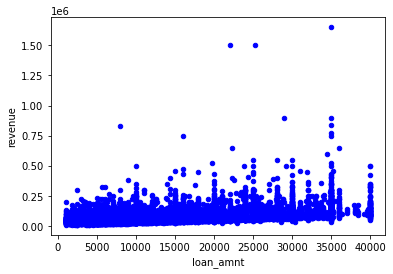

In [7]:
df.plot.scatter(x='loan_amnt', y='revenue', c='Blue')

<AxesSubplot:xlabel='loan_amnt', ylabel='fico_n'>

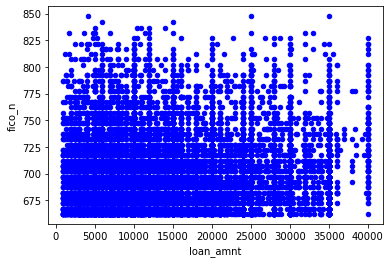

In [8]:
df.plot.scatter(x='loan_amnt', y='fico_n', c='Blue')

<AxesSubplot:xlabel='loan_amnt', ylabel='dti_n'>

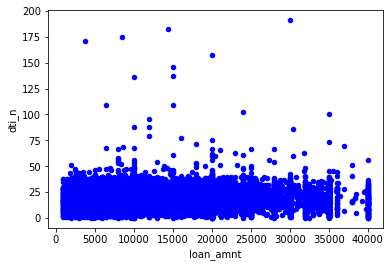

In [9]:
df.plot.scatter(x='loan_amnt', y='dti_n', c='Blue')

<AxesSubplot:xlabel='dti_n', ylabel='fico_n'>

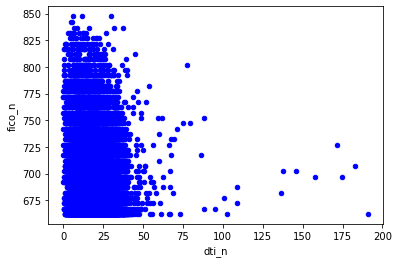

In [10]:
df.plot.scatter(x='dti_n', y='fico_n', c='Blue')

<AxesSubplot:xlabel='revenue', ylabel='dti_n'>

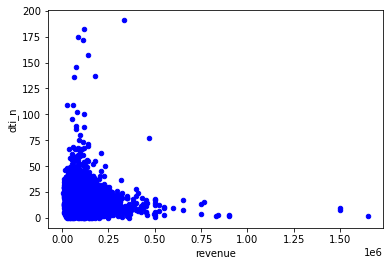

In [11]:
df.plot.scatter(x='revenue', y='dti_n', c='Blue')

<AxesSubplot:xlabel='revenue', ylabel='fico_n'>

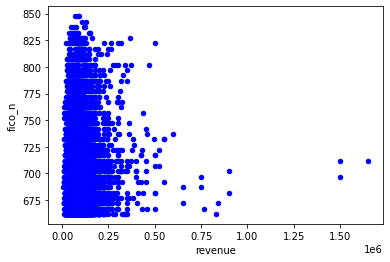

In [12]:
df.plot.scatter(x='revenue', y='fico_n', c='Blue')

Dibujamos el diagrama de dispersión para cada par de variables.

array([[<AxesSubplot:xlabel='loan_amnt', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='revenue', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='dti_n', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='fico_n', ylabel='loan_amnt'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='revenue'>,
        <AxesSubplot:xlabel='revenue', ylabel='revenue'>,
        <AxesSubplot:xlabel='dti_n', ylabel='revenue'>,
        <AxesSubplot:xlabel='fico_n', ylabel='revenue'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='dti_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='dti_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='dti_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='dti_n'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='fico_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='fico_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='fico_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='fico_n'>]], dtype=object)

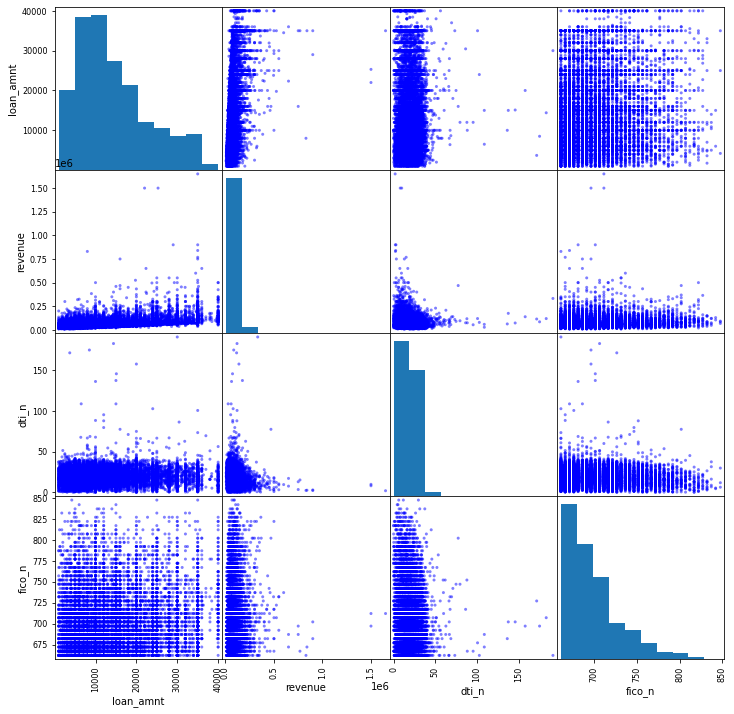

In [13]:
from pandas.plotting import scatter_matrix
%matplotlib inline

scatter_matrix(df, figsize = (12, 12), diagonal = 'hist', color='blue')

De este conjunto de diagramas, observamos que no existe ninguna relación lineal para ningún par de variables numéricas de nuestros datos (algo que ya nos esperábamos tras calcular la correlación entre ellas).
Así pues, vemos que la cantidad de dinero solicitado no depende de los ingresos anuales de cada cliente. De hecho, en la franja de gente que gana hasta 500 mil dólares al año, podemos encontrar ya todo tipo de préstamos (desde el mínimo, cero, hasta el máximo, 40 mil dólares). Algo parecido ocurre con el porcentaje de endeudamiento: lo más común es no sobrepasar el 50%, sea cual sea el crédito pedido.  Sin embargo, con la solvencia nos encontramos un escenario más heterogéneo, ya que podemos encontrarnosrelaciones de todo tipo (préstamo menor con mayor solvencia, préstamo mayor con poca solvencia, etc...).
Entre los ingresos anuales y el endeudamiento, vemos que hay una clara tendencia entre la gente que gana como máximo 500 mil dólares al año de no deber grandes porcentajes de dinero, aun que sí es cierto que hay algún caso particular que incluso supera el 100% de endeudamiento. Esto ya no se da conforme aumenta el salario/ingresos de los clientes, donde el dinero a deber alcanza, como máximo aproximado, el 40%. Con la solvencia de cada cliente con ingresos inferiores a medio millón de dólares no podemos concluir nada, puesto que llegan a abarcar todos los valores, aunque sí que se ve una menor solvencia para clientes con 
entradas mayores.


### 2.2) Categóricos

Analiza razonadamente las distribuciones de los valores de las variables categóricas incluyendo un diagrama de frecuencias y comentando lo más destacable.

In [14]:
%matplotlib inline

<AxesSubplot:>

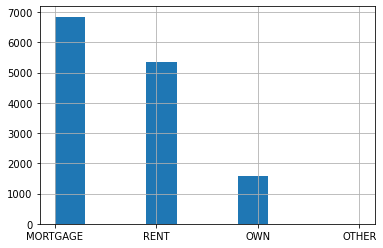

In [15]:
# Diagrama de barras mostrando cuántas veces aparece cada situación de vivienda de los solicitantes
df['home_ownership_n'].hist()

Observamos que la mayoría de los solicitantes están pagando una hipoteca, seguidos por poco de las personas que viven de alquiler y, por último, los que poseen su propia vivienda (propietarios).

<AxesSubplot:ylabel='emp_length_n'>

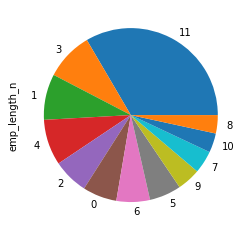

In [16]:
# Diagrama mostrando las permanencias
df['emp_length_n'].value_counts().plot.pie()

En esta gráfica podemos observar claramente que los clientes suelen confiar en la empresa de préstamo, ya que una gran parte (podríamos que estimar que aproximadamente un tercio) de ellos llevan siendo clientes durante más de 10 años (leyenda: 11 = +10 años de permanencia). Los nuevos (tienen permanencia entre 1-6 años) también conforman una gran parte del grueso de la clientela, mientras que vemos una decadencia entre los clientes con permanencia entre 7-10 años. 

<AxesSubplot:ylabel='Default'>

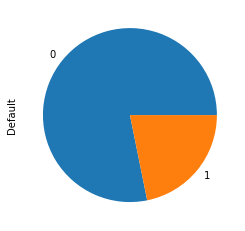

In [17]:
#Vemos cuantas personas incumplieron o no el préstamo
df['Default'].value_counts().plot.pie()

Cómo podemos observar, una gran parte de la clientela incumplió el préstamo (leyenda: 0 = inclumplió préstamo).

## 3) Preprocesar los datos

Para el clustering vamos a trabajar solamente con las variables verdaderamente numéricas. Crea un nuevo dataframe que sólo contenga las variables `loan_amnt`, `revenue`, `dti_n` y `fico_n`.

Teniendo en cuenta que vamos a utilizar el algoritmo k-Means para encontrar grupos de préstamos similares, explica razonadamente si es necesario o no cambiar la escalas de los datos y si a priori es mejor reescalarlos (MinMaxScaler) o estandarizarlos (StandarScaler).

Si decides preprocesarlos, accede al array interno del dataframe y crea un nuevo array con los datos escalados.

El algoritmo k-means es muy sensible al rango de las variables. Si una de las variables puede tomar valores mucho más grandes que otra, contribuirá mucho más a la distancia entre los puntos. Por ese motivo, suele ser una buena idea normalizar o estandarizar las variables antes de intentar agruparlas pero en este caso no sabemos nada acerca de la distribución de los datos por lo que es mejor idea reescalarlos pues las variables se encuentran en una escala muy distinta.

In [18]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
df[['loan_amnt_r','revenue_r','dti_n_r','fico_n_r']] = min_max_scaler.fit_transform(df[['loan_amnt','revenue','dti_n','fico_n']])

df.head()

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default,loan_amnt_r,revenue_r,dti_n_r,fico_n_r
0,32000,car,135000.0,18.93,687.0,MORTGAGE,1,0,0.794872,0.077906,0.099177,0.134771
1,32000,car,90000.0,9.29,822.0,MORTGAGE,10,1,0.794872,0.050517,0.048672,0.862534
2,30000,car,95000.0,1.34,722.0,RENT,11,0,0.743590,0.053561,0.007020,0.323450
3,25750,car,230000.0,6.42,747.0,MORTGAGE,11,0,0.634615,0.135727,0.033635,0.458221
4,25200,car,72000.0,30.95,692.0,OWN,11,0,0.620513,0.039562,0.162152,0.161725


## 4) Encontrar el número óptimo de clusters

Decide razonadamente el número óptimo de clusters en el rango 2..10. Ten en cuenta que para interpretar los datos no nos interesa tampoco tener un número excesivo de clusters. Para hacerlo calcula y pinta el diagrama del codo, el índice davies_boulding y el coeficiente silhouette en función del número de clusters.

In [19]:
import matplotlib.pyplot as plt

Primero, estudiamos cómo aumenta el índice de Davies–Bouldin que se define como la razón entre las distancias intra-cluster y las distancias inter-cluster. Es decir, el índice tendrá un valor más pequeño cuando más compactos y separados estén los clusters. Generamos agrupaciones con valores de K entre 2 y 10

In [20]:
from sklearn.cluster import KMeans

In [21]:
df2 = df.loc[:,['loan_amnt_r','revenue_r', 'dti_n_r','fico_n_r']]
df2

,loan_amnt_r,revenue_r,dti_n_r,fico_n_r
0,0.794872,0.077906,0.099177,0.134771
1,0.794872,0.050517,0.048672,0.862534
2,0.743590,0.053561,0.007020,0.323450
3,0.634615,0.135727,0.033635,0.458221
4,0.620513,0.039562,0.162152,0.161725
...,...,...,...,...
13789,0.007051,0.021302,0.167077,0.700809
13790,0.005128,0.017651,0.064285,0.458221
13791,0.000000,0.041996,0.132341,0.215633
13792,0.000000,0.015216,0.092733,0.458221


In [22]:
from sklearn.metrics import davies_bouldin_score
K_MAX = 11
davies_boulding = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    km = KMeans(init='random', n_clusters=k, random_state=333)
    km.fit(df2)
    
    davies_boulding[k-2] = davies_bouldin_score(df2, km.labels_) 

Text(0.5, 1.0, 'Valor de Davies Boulding para diferentes k')

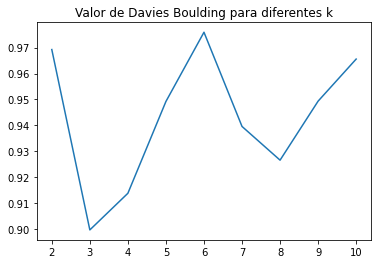

In [23]:
plt.plot(range(2, K_MAX), davies_boulding)
plt.title('Valor de Davies Boulding para diferentes k')

El mínimo valor de Davies Boulding se obtiene cuando k=3, por lo que deducimos que un número apropiado de clusters para este conjunto de datos es 3.

A continuación, utilizamos el diagrama de codo y observamos cuántos clusters nos salen con este método

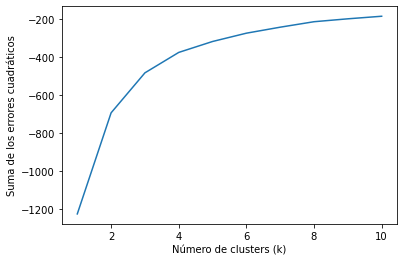

In [24]:
#Curva elbow para determinar valor óptimo de k.
nc = range(1, 11) # El número de iteraciones que queremos hacer.
kme = [KMeans(n_clusters=i) for i in nc]
score = [kme[i].fit(df2).score(df2) for i in range(len(kme))]
score
plt.xlabel('Número de clusters (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

La curva elbow nos muestra que un valor de k = 3 puede ser apropiado, aunque se podría probar con 4,5,6 y comparar resultados. No hay una solución, un valor de k, más correcto que otro, ya que el objetivo de una clusterización con k-means es obtener información útil nuestros datos, por lo que nuestra interpretación a posteriori de los clusters creados marcará la calidad de nuestra solución escogida.

Para ya finalmente concluir que k = 3 es el número óptimo de clusters, calculamos el índice de silueta para k=3,4,5 y analizamos el resultado.

In [25]:
from sklearn.metrics import silhouette_score
# Calculamos Silhoutte Score

#Aplicamos kmeans con k = 3
for k in range(3,6):
    km = KMeans(n_clusters=k).fit(df2)
    score = silhouette_score(df2, km.labels_, metric='euclidean')
    print("Silhouette Score for k =", k, ": ", score)

Silhouette Score for k = 3 :  0.4083055576482024
Silhouette Score for k = 4 :  0.3575548232180971
Silhouette Score for k = 5 :  0.3456099804650224


Todos los valores son positivos, lo que nos indica que la partición es correcta, pero, además, todos ellos son más cercanos al 0 que al 1, por lo que es posible que haya algo de solapamiento entre los clusters. Cómo habíamos imaginado, con k=3 el índice de silueta alcanza su mayor valor, por lo que concluimos que éste será nuestro número de clusters.  

## 5) Descripción de los clusters

Describe los clusters que has obtenido en el apartado anterior. Si te han salido más de 3, elige 3 de ellos que sean bastante diferentes entre sí. 

Para hacerlo estudia sus descriptores estadísticos y dales un sentido dentro del contexto del problema. ¿Qué perfil de préstamos quedan en cada cluster? Según dicho perfil, ¿qué cluster te parece que tendrá una mayor tasa de "default"? Corrobóralo calculando para cada cluster la proporción de préstamos que acabaron en "default".

Pinta el diagrama de dispersión en función de cada par de variables usando colores diferentes para cada cluster. ¿Qué clusters se separan mejor y en función de qué variables? ¿y cuáles se confunden más?

__Cuidado__: para poder interpretar correctamente los datos necesitas que estén en su escala original. Si decidiste escalar los datos, deberás ejecutar k-Means con los datos escalados pero asignar las etiquetas de clusters al conjunto de datos inicial. En este caso es muy sencillo porque el algoritmo no cambia el orden de los datos así que puedes crear directamente una nueva columna en el dataframe original con esas etiquetas. Puede que aparezca un SettingWithCopyWarning por asignar una nueva columna en un dataframe que es una vista de otro dataframe. Puedes ignorar este aviso o puedes hacer una copia del dataframe con `copy` para que no comparta memoria con el otro.

Cómo ya hemos indicado en el apartado anterior, el número óptimo de clusters es 3. Ahora, aplicamos el algoritmo kMeans, que agrupa los datos en K grupos disjuntos de forma que se minimiza la suma de distancias dentro de cada cluster.

In [26]:
#Aplicamos kmeans con k = 3
kmeans = KMeans(n_clusters=3).fit(df2)

A continuación, añadimos la etiqueta de _cluster_ a cada uno de nuestros clientes, para ver a cuál pertenecen y así poder observar con facilidad los estadísticos descriptivos.

In [27]:
#Observamos el dataframe etiquetado
df_etiquetado = pd.DataFrame(data=df2)
df_etiquetado = df_etiquetado.assign(cluster=pd.Series(data=kmeans.labels_))
df_etiquetado

,loan_amnt_r,revenue_r,dti_n_r,fico_n_r,cluster
0,0.794872,0.077906,0.099177,0.134771,1
1,0.794872,0.050517,0.048672,0.862534,2
2,0.743590,0.053561,0.007020,0.323450,1
3,0.634615,0.135727,0.033635,0.458221,1
4,0.620513,0.039562,0.162152,0.161725,1
...,...,...,...,...,...
13789,0.007051,0.021302,0.167077,0.700809,2
13790,0.005128,0.017651,0.064285,0.458221,2
13791,0.000000,0.041996,0.132341,0.215633,0
13792,0.000000,0.015216,0.092733,0.458221,2


Como queremos los datos en su escala original para poder interpretarlos mejor, etiquetamos el dataframe original con la columna de clusters puesto que el algoritmo no ha cambiado el orden de los datos.

In [28]:
df["cluster"] = df_etiquetado["cluster"]
df_final = df.drop(['loan_amnt_r','revenue_r', 'dti_n_r','fico_n_r'], axis=1)
df_final

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default,cluster
0,32000,car,135000.0,18.93,687.0,MORTGAGE,1,0,1
1,32000,car,90000.0,9.29,822.0,MORTGAGE,10,1,2
2,30000,car,95000.0,1.34,722.0,RENT,11,0,1
3,25750,car,230000.0,6.42,747.0,MORTGAGE,11,0,1
4,25200,car,72000.0,30.95,692.0,OWN,11,0,1
...,...,...,...,...,...,...,...,...,...
13789,1275,vacation,42000.0,31.89,792.0,RENT,0,0,2
13790,1200,vacation,36000.0,12.27,747.0,MORTGAGE,8,0,2
13791,1000,vacation,76000.0,25.26,702.0,MORTGAGE,11,0,0
13792,1000,vacation,32000.0,17.70,747.0,MORTGAGE,0,0,2


In [43]:
#Agrupamos los datos por clusters, y así podemos ver sus valores para la media, la moda, desviación típica, mínimo, 
#máximo y percentiles para cada uno de los datos.
df_final.groupby(["cluster"]).describe()

loan_amnt                                                        \
            count          mean          std      min      25%      50%   
cluster                                                                   
0          7489.0   9440.606222  4392.061290   1000.0   6000.0   9700.0   
1          3879.0  26373.188966  5888.811039  17375.0  20750.0  25000.0   
2          2426.0  11178.380049  5830.861894   1000.0   6075.0  10000.0   

                          revenue                 ...  dti_n          fico_n  \
             75%      max   count           mean  ...    75%     max   count   
cluster                                           ...                          
0        12600.0  19075.0  7489.0   65363.467390  ...  24.84  182.81  7489.0   
1        30000.0  40000.0  3879.0  111112.368350  ...  25.02  190.87  3879.0   
2        15000.0  35000.0  2426.0   73942.467143  ...  23.76  171.39  2426.0   

                                                                   
               mean        std    min    25%    50%    75%    max  
cluster                                                            
0        682.964748  15.861163  662.0  667.0  682.0  697.0  722.0  
1        698.630575  27.777442  662.0  677.0  692.0  712.0  827.0  
2        749.698475  27.430964  717.0  727.0  742.0  767.0  847.5  

[3 rows x 32 columns]

Analizamos a continuación los datos de cada cluster. Observamos primeramente que el cluster 0 es el más numeroso con una gran diferencia respecto a los otros dos. El siguiente más numeroso es el 1 y el siguiente el 2.

Observando los estadísticos de las variables vemos que el cluster 0 agrupa los préstamos en general con menos loan_amnt (préstamos pequeños). En el cluster 1 en cambio, se agrupan los mayores valores de cantidad de dinero solicitada y el cluster 2 está entre el 0 y el 1 aunque está más cerca de los valores del 0 que del 1. Los valores dti_n y revenue no diferencian mucho los clusters ya que tienen estadísticos y valores similares. En cuanto al valor de fico_n, vemos que en el cluster 1 hay todo tipo de valore entre el 662 y 827 (tiene un amplio rango de fico_n comparado con los otros clusters). En el cluster 0 la solvencia es menor en general y en el cluster 2 mayor.

Concluimos que el cluster 0 agrupa la mayor cantidad de  préstamos y que estos son los de menor cantidad de dinero, es decir, la mayoría de los préstamos son pequeños. La solvencia de los solicitantes en este cluster es elevada por lo que podemos especular que no va a haber mucha proporción préstamos incumplidos en este cluster. El cluster 2 es en el que mayor solvencia tienen los clientes y los préstamos son de todo tipo. Sin embargo en el cluster 1 se agrupan los préstamos de mayor cantidad de dinero y la solvencia tiene un rango de valores muy grandes. Por ello al tener solvencias bajas dentro del cluster y grandes préstamos, puede ser prevesiblemente el cluster con más proporción de préstamos incumplidos.

Destacamos que las especulaciones son a partir de los datos de las variables. El tamaño del cluster 0 es prácticamente el doble que el siguiente mayor por lo que por cantidad de préstamos, es probable que haya bastantes incumplidos.



Ahora, sólo nos queda expresar visualmente los datos, diferenciando por clusters. Para ello, definimos una función sencilla (plot_clusters_multVar) que nos dibujará los datos en diagramas de dispersión para cada par de variables, diferenciando por colores a cada uno de los clusters.

In [30]:
def plot_clusters_multVar(X, labels):
    colors = ['r','g','b','c','y','k','m']
    pd.plotting.scatter_matrix(X, figsize=(12,12), c=labels, diagonal='kde')

In [31]:
# Creamos una instancia del agrupador k-means, agrupando los puntos en 3 clusters
km_ = KMeans(init='random', n_clusters=3, random_state=333)
km_.fit(df2)

KMeans(init='random', n_clusters=3, random_state=333)

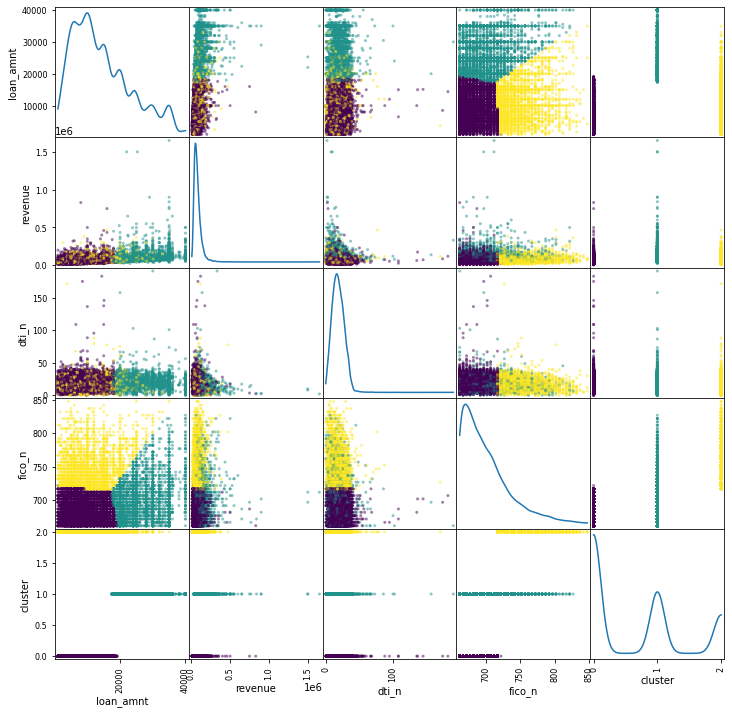

In [32]:
plot_clusters_multVar(df_final, km_.labels_)

Como habíamos analizado anteriormente, los clusters tienen valores similares en dti_n y revenue por lon que estas dos variables no nos sirven mucho para diferenciar los clusters. en cuanto a loan_amnt, como habíamos dicho, diferencia claramente los clusters siendo el morado (cluster 0) el que tiene valores menores, el azul (1) mayores y el amarillo gran variedad de valores.
En cuanto a la variable fico_n observamos lo dicho arriba, el cluster morado es el que menores valores tiene, el amarillo el que más y el azul gran variedad de valores.

A partir de esto vemos en la gráfica que las variables que más diferencian los clusters son loan_amnt y fico_n (se observan claramente los tres cluster separados en las gráficas que involucran estas dos variables.

Las variables que menos los diferencian son revenue y dti_n y vemos que en la gráfica que las relaciona, se observa una mezcla de colores y no hay ninguna distinción de clusters.